# Recommender Systems 2023/24

### Practice 3 - Content Based recommenders


### Load the data you saw last time:

In [1]:
from urllib.request import urlretrieve
import zipfile, os

# If file exists, skip the download
data_file_path = "Data_manager_split_datasets/Movielens10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)
    
dataFile = zipfile.ZipFile(data_file_path + "movielens_10m.zip")

URM_path = dataFile.extract("ml-10M100K/ratings.dat", path = data_file_path + "decompressed/")

URM_file = open(URM_path, 'r')

In [2]:
import pandas as pd

URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep="::", 
                                header=None, 
                                dtype={0:int, 1:int, 2:float, 3:int},
                                engine='python')

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction", "Timestamp"]

In [3]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction,Timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392
5,1,329,5.0,838983392
6,1,355,5.0,838984474
7,1,356,5.0,838983653
8,1,362,5.0,838984885
9,1,364,5.0,838983707


## And now load the content informations in the same way:
## In this case we are using tags. The ICM also contains the user that added the tag in column 0 (but we don't use that information).

In [4]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = data_file_path + "decompressed/")

ICM_dataframe = pd.read_csv(filepath_or_buffer=ICM_path, 
                            sep="::", 
                            header=None, 
                            dtype={0:int, 1:int, 2:str, 3:int},
                            engine='python')

ICM_dataframe.columns = ["UserID", "ItemID", "FeatureID", "Timestamp"]

# Some nan values exist, remove them
ICM_dataframe = ICM_dataframe[ICM_dataframe["FeatureID"].notna()]

In [5]:
ICM_dataframe.head(n=10)

,UserID,ItemID,FeatureID,Timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835
5,20,2424,ryan,1188263835
6,20,2947,action,1188263755
7,20,2947,bond,1188263756
8,20,3033,spoof,1188263880
9,20,3033,star wars,1188263880


### We can see that most users and items have no data associated to them

In [6]:
n_features = len(ICM_dataframe["FeatureID"].unique())

print ("Number of tags\t {}, Number of item-tag tuples {}".format(n_features, len(ICM_dataframe)))

Number of tags	 16528, Number of item-tag tuples 95564


## We now build the sparse URM and ICM matrices

### The tags are strings, we should traslate them into numbers so we can use them as indices in the ICM.
### We should also ensure that the item and user indices we use in ICM and URM are consistent. To do so we use the same mapper, first we populate it with the URM and then we add the new ids that appear only in the ICM

In [7]:
mapped_id, original_id = pd.factorize(URM_all_dataframe["UserID"].unique())

print("Unique UserID in the URM are {}".format(len(original_id)))

all_item_indices = pd.concat([URM_all_dataframe["UserID"], ICM_dataframe["UserID"]], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique UserID in the URM and ICM are {}".format(len(original_id)))

user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

Unique UserID in the URM are 69878
Unique UserID in the URM and ICM are 71567


In [8]:
mapped_id, original_id = pd.factorize(URM_all_dataframe["ItemID"].unique())

print("Unique ItemID in the URM are {}".format(len(original_id)))

all_item_indices = pd.concat([URM_all_dataframe["ItemID"], ICM_dataframe["ItemID"]], ignore_index=True)
mapped_id, original_id = pd.factorize(all_item_indices.unique())

print("Unique ItemID in the URM and ICM are {}".format(len(original_id)))

item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

Unique ItemID in the URM are 10677
Unique ItemID in the URM and ICM are 10681


In [9]:
mapped_id, original_id = pd.factorize(ICM_dataframe["FeatureID"].unique())
feature_original_ID_to_index = pd.Series(mapped_id, index=original_id)

print("Unique FeatureID in the URM are {}".format(len(feature_original_ID_to_index)))

Unique FeatureID in the URM are 16528


In [10]:
original_feature_ID = "star wars"
print("New index for feature '{}' is {}".format(original_feature_ID, feature_original_ID_to_index[original_feature_ID]))

New index for feature 'star wars' is 9


# We can now build the URM and ICM using the new indices


In [11]:
URM_all_dataframe["UserID"] = URM_all_dataframe["UserID"].map(user_original_ID_to_index)
URM_all_dataframe["ItemID"] = URM_all_dataframe["ItemID"].map(item_original_ID_to_index)

In [12]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction,Timestamp
0,0,0,5.0,838985046
1,0,1,5.0,838983525
2,0,2,5.0,838983392
3,0,3,5.0,838983421
4,0,4,5.0,838983392
5,0,5,5.0,838983392
6,0,6,5.0,838984474
7,0,7,5.0,838983653
8,0,8,5.0,838984885
9,0,9,5.0,838983707


In [13]:
ICM_dataframe["UserID"] = ICM_dataframe["UserID"].map(user_original_ID_to_index)
ICM_dataframe["ItemID"] = ICM_dataframe["ItemID"].map(item_original_ID_to_index)
ICM_dataframe["FeatureID"] = ICM_dataframe["FeatureID"].map(feature_original_ID_to_index)

In [14]:
ICM_dataframe.head(n=10)

,UserID,ItemID,FeatureID,Timestamp
0,69878,1926,0,1215184630
1,69879,1040,1,1188263867
2,69879,1040,2,1188263867
3,69879,1086,3,1188263835
4,69879,1086,4,1188263835
5,69879,1086,5,1188263835
6,69879,612,6,1188263755
7,69879,612,7,1188263756
8,69879,628,8,1188263880
9,69879,628,9,1188263880


### When we create the matrices we need to make sure they have the same shape. As we have seen some items and users only appear in one of the two matrices and are missing in the other (if they have no tags or no interactions)

In [15]:
import scipy.sparse as sps
import numpy as np

n_users = len(user_original_ID_to_index)
n_items = len(item_original_ID_to_index)
n_features = len(feature_original_ID_to_index)

In [16]:
URM_all = sps.csr_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)),
                        shape = (n_users, n_items))

URM_all

<71567x10681 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in Compressed Sparse Row format>

In [17]:
ICM_all = sps.csr_matrix((np.ones(len(ICM_dataframe["ItemID"].values)), 
                          (ICM_dataframe["ItemID"].values, ICM_dataframe["FeatureID"].values)),
                        shape = (n_items, n_features))

ICM_all.data = np.ones_like(ICM_all.data)

ICM_all

<10681x16528 sparse matrix of type '<class 'numpy.float64'>'
	with 71140 stored elements in Compressed Sparse Row format>

# Let's take a look at the ICM

### We leverage CSR and CSC indptr data structure to compute the number of cells that have values for that row or column

In [18]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [19]:
print(features_per_item.shape)
print(items_per_feature.shape)

(10681,)
(16528,)


In [20]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

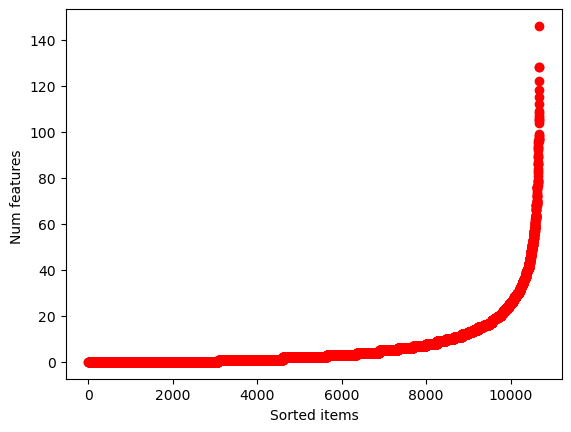

In [21]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Sorted items')
pyplot.show()

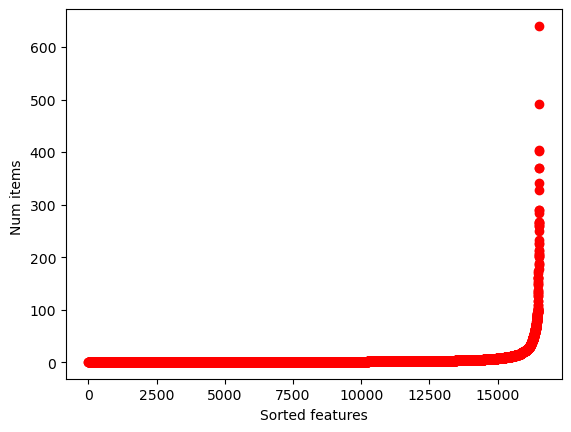

In [22]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Sorted features')
pyplot.show()

# We can now build the recommender algorithm, but first we need the train/test split and the evaluation function:

In [23]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 1939 ( 2.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1778 ( 2.5%) Users that have less than 1 test interactions


### We need to define Cosine similarity... Let's look at the attached source code

### See also a [list of commonly used KNN similarity heuristics](https://github.com/MaurizioFD/RecSys_Course_2018/blob/master/slides/List_of_KNN_similarity_heuristics.pdf)

## A KNN is built with the following steps:
* Compute the similarity of an item with all others
* Select the k-highest similarities

In [24]:
item_id = 80
shrink = 10

The numerator is the dot product of the item features times the whole ICM data transposed

In [25]:
numerator_vector = ICM_all[item_id].dot(ICM_all.T).toarray().ravel()
numerator_vector

array([2., 0., 0., ..., 0., 1., 0.])

In [26]:
item_norms = np.sqrt(np.array(ICM_all.T.power(2).sum(axis=0))).ravel()
item_norms

array([1.73205081, 4.35889894, 5.29150262, ..., 1.        , 1.41421356,
       1.41421356])

The denominator will be the product of norms plus the srink term and a small value which prevents the denominator to be zero (only for non-negative data)

In [27]:
denominator_vector = item_norms[item_id] * item_norms + shrink + 1e-6
denominator_vector

array([15.47722658, 23.78404975, 26.73320153, ..., 13.16227866,
       14.47213695, 14.47213695])

In [28]:
similarity_vector = numerator_vector/denominator_vector

Let's sort the similarity from the highest to the lowest

In [29]:
sorted_item_indices = np.argsort(-similarity_vector)
sorted_item_indices

array([   80,  3542,     0, ...,  3938,  3931, 10680], dtype=int64)

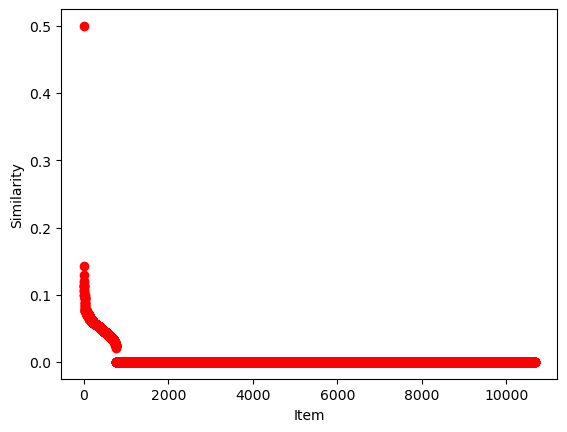

In [30]:
pyplot.plot(similarity_vector[sorted_item_indices], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

Now we select the k most similar items

In [31]:
k = 100

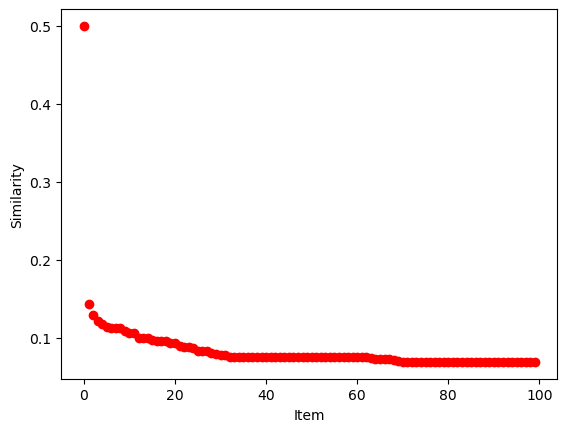

In [32]:
pyplot.plot(similarity_vector[sorted_item_indices[0:k]], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

The operation is performed for all items.
A simple strategy to perform it efficiently is to vectorize the most computationally intensive part, the dot product, on a group of items. The speedup can be of a factor of 10-100.
This strategy is limited by the fact that the result of the dot product is a huge item-item dense similarity which likely does not fit in memory.

In [33]:
import traceback

try:
    numerator_matrix = ICM_all.dot(ICM_all.T).toarray()
    
except Exception as e:
    traceback.print_exc()
    

The solution is:
* Compute the numerator a block of items at a time leveraging vectorization while not running out of memory
* Extract the k-nn on those items
* Built incrementally the sparse similarity matrix

In [34]:
block_size = 100

numerator_block = ICM_all[0:block_size].dot(ICM_all.T).toarray()
numerator_block.shape

(100, 10681)

Let's compare the speed to compute the dot product on the whole similarity of the two strategies

In [35]:
import time

n_items = ICM_all.shape[0]

start_time = time.time()

for n_item in range(n_items):
    numerator_vector = ICM_all[item_id].dot(ICM_all.T).toarray().ravel()
    
end_time = time.time()

print("Computing the similarity one item at a time runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))

Computing the similarity one item at a time runs at 901.44 items/sec


In [36]:
n_items = ICM_all.shape[0]

start_time = time.time()

block_size = 100
blocks_start_positions = range(0, n_items, block_size)

for start_pos in blocks_start_positions:
    end_pos = min(start_pos + block_size, n_items)
    
    numerator_block = ICM_all[start_pos:end_pos].dot(ICM_all.T).toarray()
    
end_time = time.time()

print("Computing the similarity in blocks of 100 items at a time runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))

Computing the similarity in blocks of 100 items at a time runs at 20876.37 items/sec


### In this case the vectorized implementation runs >20 times faster!

#### Usually most of the speed gain comes with blocks of 100 or so items, depending on the system. Much higher than that tends to not be beneficial while requiring increasingly more memory.

Now an example of something you should *never* do, nested loops to compute the similarity of each item without vectorization

In [37]:
n_items = 100

start_time = time.time()

for n_item in range(n_items):
    for second_item in range(n_items):
        numerator_vector = ICM_all[item_id].dot(ICM_all[second_item].T)
    
end_time = time.time()

print("Computing the similarity with nested loops runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))

Computing the similarity with nested loops runs at 25.47 items/sec


You see how incredibly slow nested loops are compared to a well vectorized implementation

#### Let's now compute the entire similarity matrix and use it to generate recommendations

In [38]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(ICM_all.T, shrink=0.0, 
                                          topK=100,
                                          normalize=True, 
                                          similarity = "cosine")

W_sparse = similarity_object.compute_similarity()
W_sparse

Similarity column 10681 (100.0%), 2754.21 column/sec. Elapsed time 3.88 sec


<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 624041 stored elements in Compressed Sparse Row format>

In [39]:
user_id = 200
user_profile = URM_train[user_id]

scores = user_profile.dot(W_sparse)
scores

<1x10681 sparse matrix of type '<class 'numpy.float64'>'
	with 5579 stored elements in Compressed Sparse Row format>

In [40]:
scores = scores.toarray().ravel()
scores

array([1.22474447, 4.02028234, 6.30255866, ..., 0.        , 1.49999928,
       0.        ])

We can then sort the scores to recommend the highest ranked ones

In [41]:
ranking = scores.argsort()[::-1][0:10]
ranking

array([3082, 7714,  436, 6302,   24, 2643,   37,  235,  177, 3734],
      dtype=int64)

In [42]:
scores[ranking]

array([23.85221259, 23.85221259, 21.72780634, 21.56574956, 21.18882509,
       20.8332223 , 20.36917911, 20.00777917, 18.2307644 , 17.74951704])

## Test our CBF recommender:

#### We put everything in a Python class with a standard interface

In [43]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

class ItemKNNCBFRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [44]:
recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 10681 (100.0%), 3328.22 column/sec. Elapsed time 3.21 sec


In [45]:
for user_id in range(10):
    print(recommender.recommend(user_id, at=5))

[1757 1375  835  554  851]
[177 196 822 192 401]
[5660 5664   64  798 3318]
[ 175 1331   31  228  401]
[  7 176 403 148 402]
[798 822  22 943  60]
[ 219  164   44 2207 1441]
[  37 2755 4636 3736 1609]
[ 585  213  616  788 4390]
[  34 1310   22   26 1314]


#### Let's talk about speed

#### Time to compute recommendations for a fixed group of users

In [46]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

Reasonable implementation speed is 714.50 usr/sec


### Let's add a common mistake.... a CSC URM

In [47]:
URM_train_csc = URM_train.tocsc()

recommender = ItemKNNCBFRecommender(URM_train_csc, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 10681 (100.0%), 3146.38 column/sec. Elapsed time 3.39 sec


In [48]:
import time, traceback

try:

    n_users_to_test = 1000

    start_time = time.time()

    for user_id in range(n_users_to_test):
        recommender.recommend(user_id, at=5)

    end_time = time.time()

    print("Wrong implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

    
except Exception as e:
        
    print("Exception {}".format(str(e)))
    traceback.print_exc()

Exception index 10719 is out of bounds for axis 0 with size 10681


Traceback (most recent call last):
  File "C:\Users\MaurizioFD\AppData\Local\Temp\ipykernel_8816\1155062715.py", line 10, in <module>
    recommender.recommend(user_id, at=5)
  File "C:\Users\MaurizioFD\AppData\Local\Temp\ipykernel_8816\4145966258.py", line 25, in recommend
    scores = self.filter_seen(user_id, scores)
  File "C:\Users\MaurizioFD\AppData\Local\Temp\ipykernel_8816\4145966258.py", line 40, in filter_seen
    scores[user_profile] = -np.inf
IndexError: index 10719 is out of bounds for axis 0 with size 10681


## Hyperparameter tuning

#### Once we have built our model we can play with its hyperparameters
* Number of neighbors
* Shrinkage
* Similarity type


Do not confuse "hyperparameter" with "parameter". A hyperparameter is someting that influences the model structure (number of neighbors, similarity type) or its training phase (learning rate, regularization), while the parameters are the model components (for example the actual value of the similarity between two items) whose values are learned with machine learning.

### Number of neighbors

#### First let's use Grid Search. To do that we need to specify a list of values to test. Grid search is simple to implement but is largely obsolete, it is widely known that it is very inefficient and difficult to set up correctly (which values do you choose?). It is strongly discouraged.

### Even better, use a random search!

#### Just use a random number generator to select the values you want. It is more efficient than greed search and just as simple to implement. It is important to decide if we want to sample with a random distribution or a log-uniform distribution. Use a log-uniform if you need to sample both high and low values, for example you want to sample with uniform probability 10, 20 but also 100 and 200.

In this example we will operate sequentially, first by choosing the optimal number of neighbors and then by choosing the shrink value. Alternatively one could search over both hyperparameters at the same time. With a Random search you just need to generate another group of values, with Grid search you need to try all possible shrink values for each neighbor (this creates a carthesian product of the values and is the reason it is called "grid")

In [49]:
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from scipy.stats import loguniform

MAP_per_k_grid = pd.DataFrame(columns = ["k", "MAP"])
MAP_per_k_grid["k"] = [10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000]

MAP_per_k_rnd = pd.DataFrame(columns = ["k", "MAP"])
MAP_per_k_rnd["k"] = loguniform.rvs(10, 1000, size=len(MAP_per_k_grid)).astype(int)
MAP_per_k_rnd = MAP_per_k_rnd.sort_values(by="k")


for index in MAP_per_k_grid.index:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=MAP_per_k_grid.loc[index,"k"])
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    MAP_per_k_grid.loc[index,"MAP"] = result_df.loc[10]["MAP"]

    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=MAP_per_k_rnd.loc[index,"k"])
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    MAP_per_k_rnd.loc[index,"MAP"] = result_df.loc[10]["MAP"]

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 80 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 14379.67 column/sec. Elapsed time 0.74 sec
EvaluatorHoldout: Processed 69628 (100.0%) in 45.40 sec. Users per second: 1534
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 80 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 15253.70 column/sec. Elapsed time 0.70 sec
EvaluatorHoldout: Processed 69628 (100.0%) in 49.36 sec. Users per second: 1410
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 80 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity 

Similarity column 10681 (100.0%), 14088.80 column/sec. Elapsed time 0.76 sec
EvaluatorHoldout: Processed 69628 (100.0%) in 1.06 min. Users per second: 1092
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 80 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 14280.24 column/sec. Elapsed time 0.75 sec
EvaluatorHoldout: Processed 69628 (100.0%) in 1.13 min. Users per second: 1030
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 80 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 14295.71 column/sec. Elapsed time 0.75 sec
EvaluatorHoldout: Processed 69628 (100.0%) in 54.84 sec. Users per second: 1270


In [50]:
MAP_per_k_grid

,k,MAP
0,10,0.035159
1,50,0.042957
2,100,0.039651
3,150,0.035309
4,200,0.02867
5,250,0.023846
6,300,0.023227
7,350,0.024986
8,400,0.024797
9,450,0.025786


In [75]:
MAP_per_k_rnd

,k,MAP
5,29,0.041944
0,45,0.042971
1,60,0.043182
8,71,0.041821
9,77,0.041399
3,140,0.036644
6,145,0.035952
7,148,0.035581
11,182,0.030547
2,241,0.025278


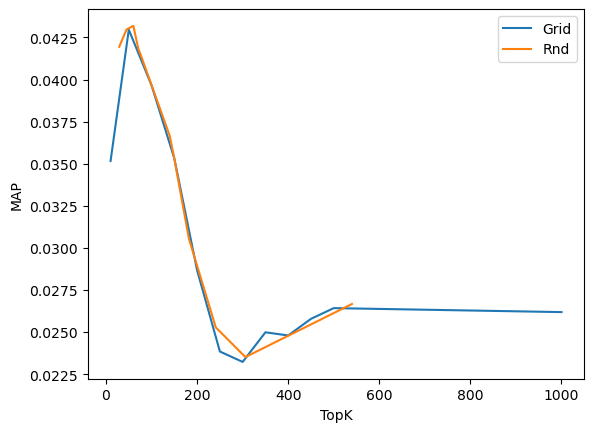

In [51]:
pyplot.plot(MAP_per_k_grid["k"].values, MAP_per_k_grid["MAP"].values, label="Grid")
pyplot.plot(MAP_per_k_rnd["k"].values, MAP_per_k_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.legend()
pyplot.show()

#### On this dataset the number of neighbors has a small absolute impact on MAP but a large relative one. Fine-tuning around the best values is needed.

#### Different datasets will behave in different ways.

### Shrinkage

- Select the best number of neighbors, then use this to choose the shrink term

In [52]:
best_k_value = MAP_per_k_rnd.loc[MAP_per_k_rnd["MAP"].astype(float).idxmax()]
best_k_value

k            60
MAP    0.043182
Name: 1, dtype: object

In [53]:
MAP_per_shrinkage_grid = pd.DataFrame(columns = ["k", "shrink", "MAP"])
MAP_per_shrinkage_grid["shrink"] = [0, 10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 1000]
MAP_per_shrinkage_grid["k"] = best_k_value["k"]


MAP_per_shrinkage_rnd = pd.DataFrame(columns = ["k", "shrink", "MAP"])
MAP_per_shrinkage_rnd["shrink"] = loguniform.rvs(0.1, 1000, size=len(MAP_per_shrinkage_grid)).astype(int)
MAP_per_shrinkage_rnd = MAP_per_shrinkage_rnd.sort_values(by="shrink")
MAP_per_shrinkage_rnd["k"] = best_k_value["k"]


for index in MAP_per_shrinkage_grid.index:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=MAP_per_shrinkage_grid.loc[index,"shrink"], topK=MAP_per_shrinkage_grid.loc[index,"k"])
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    MAP_per_shrinkage_grid.loc[index,"MAP"] = result_df.loc[10]["MAP"]

    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=MAP_per_shrinkage_rnd.loc[index,"shrink"], topK=MAP_per_shrinkage_rnd.loc[index,"k"])
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    MAP_per_shrinkage_rnd.loc[index,"MAP"] = result_df.loc[10]["MAP"]

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 80 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 15238.83 column/sec. Elapsed time 0.70 sec
EvaluatorHoldout: Processed 69628 (100.0%) in 47.44 sec. Users per second: 1468
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 80 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 14488.71 column/sec. Elapsed time 0.74 sec
EvaluatorHoldout: Processed 69628 (100.0%) in 49.45 sec. Users per second: 1408
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 80 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity 

Similarity column 10681 (100.0%), 14434.05 column/sec. Elapsed time 0.74 sec
EvaluatorHoldout: Processed 69628 (100.0%) in 52.29 sec. Users per second: 1332
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 80 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 13747.47 column/sec. Elapsed time 0.78 sec
EvaluatorHoldout: Processed 69628 (100.0%) in 53.61 sec. Users per second: 1299
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 80 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 14776.09 column/sec. Elapsed time 0.72 sec
EvaluatorHoldout: Processed 69628 (100.0%) in 49.93 sec. Users per second: 1394
ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
It

In [54]:
MAP_per_shrinkage_grid

,k,shrink,MAP
0,60,0,0.043182
1,60,10,0.05449
2,60,50,0.056564
3,60,100,0.057695
4,60,150,0.057737
5,60,200,0.05777
6,60,250,0.057875
7,60,300,0.057479
8,60,350,0.057239
9,60,400,0.057157


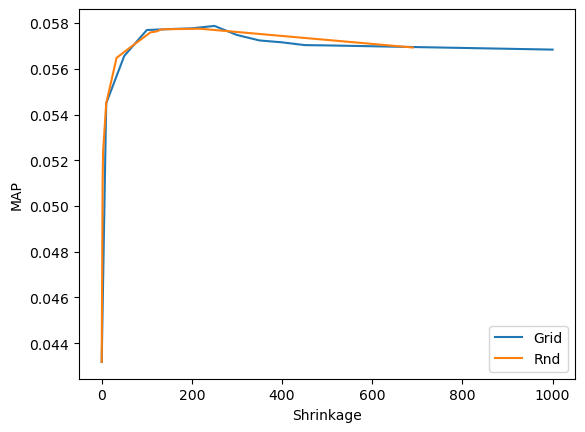

In [78]:
pyplot.plot(MAP_per_shrinkage_grid["shrink"].values, MAP_per_shrinkage_grid["MAP"].values, label="Grid")
pyplot.plot(MAP_per_shrinkage_rnd["shrink"].values, MAP_per_shrinkage_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.legend()
pyplot.show()

The shrinkage value (i.e. support) has a much stronger impact. Combine a hyperparameter search with the two to ensure maximum recommendation quality

We now would like to use the hyperparameters we found to train the model that will be evaluated on the test data. We need to
* Select the best hyperparameters based on the validation data
* Train the model again on the union of training and validation data
* Compute the recommendations

In [79]:
MAP_per_shrinkage_rnd

,k,shrink,MAP
0,60,0,0.043182
8,60,0,0.043182
11,60,0,0.043182
2,60,2,0.050998
3,60,3,0.052349
5,60,10,0.05449
10,60,33,0.056479
6,60,57,0.056842
4,60,108,0.057591
9,60,121,0.057632


In [57]:
optimal_hyperparams = MAP_per_shrinkage_rnd.loc[MAP_per_shrinkage_rnd['MAP'].astype(float).idxmax()]
optimal_hyperparams

k               60
shrink         218
MAP       0.057753
Name: 1, dtype: object

In [58]:
recommender = ItemKNNCBFRecommender(URM_train + URM_validation, ICM_all)
recommender.fit(shrink=optimal_hyperparams["shrink"], topK=optimal_hyperparams["k"])


result_df, _ = evaluator_test.evaluateRecommender(recommender)
result_df

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 42 ( 0.4%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 15454.39 column/sec. Elapsed time 0.69 sec
EvaluatorHoldout: Processed 69789 (100.0%) in 54.16 sec. Users per second: 1289


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.16959,0.181455,0.073901,0.114153,0.119804,0.408563,0.173134,0.102943,0.630615,0.650592,...,0.975156,0.614948,0.975156,0.007153,6.506814,0.983407,0.036735,0.574559,1.780377,0.074283



## Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# Feature weighting

# IDF

![title](https://www.link-assistant.com/images/news/tf-idf-tool-for-seo/screen-03.png)

In [59]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = np.ediff1d(sps.csc_matrix(ICM_all).indptr)

IDF = np.log(num_tot_items / items_per_feature)

print(ICM_all.shape)
print(IDF.shape)

(10681, 16528)
(16528,)


In [60]:
np.sort(items_per_feature)

array([  1,   1,   1, ..., 404, 492, 640], dtype=int32)

In [61]:
np.sort(IDF)

array([2.81475356, 3.07774302, 3.27480686, ..., 9.27622174, 9.27622174,
       9.27622174])

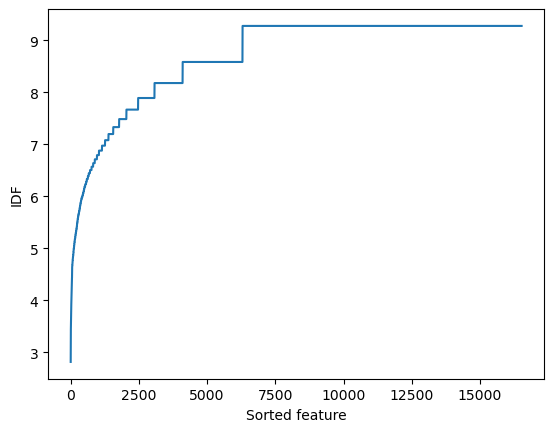

In [62]:
pyplot.plot(np.sort(IDF))
pyplot.ylabel('IDF')
pyplot.xlabel('Sorted feature')
pyplot.show()

#### Highest ranked features

In [63]:
feature_index_to_original_ID_dict = {value:key for key,value in feature_original_ID_to_index.iteritems()}

In [64]:
sorted_features = np.argsort(-IDF)

highest_ranked_features = sorted_features[:20]

for feature_index in highest_ranked_features:
    print(feature_index_to_original_ID_dict[feature_index])

a old story of fight
i hate this movie with a fiery passion
so damn good
cool-ish
i love this movie
ukraine
don't watch it again
NOT Eugene O'Neill - S. Africa
why do i hate this?
Yakuza Papers I
needless gratuitous violence
always applicable to present
insanely funny
homoerotic hobbit-on-hobbit action
musical score drives me crazy!
brilliant in concept & execution
modern male friendship
almost favourite
this movie is pretty...pretty gay
instant classic


#### Lowest ranked features

In [65]:
lowest_ranked_features = sorted_features[-20:]

for feature_index in lowest_ranked_features:
    print(feature_index_to_original_ID_dict[feature_index])    

atmospheric
library
seen more than once
Nudity (Topless - Brief)
To See
adapted from:book
imdb top 250
Can't remember
classic
Bibliothek
National Film Registry
Betamax
movie to see
Nudity (Topless)
based on a book
70mm
R
erlend's DVDs
less than 300 ratings
Tumey's DVDs


In [66]:
from scipy.sparse import diags
diags(IDF)

<16528x16528 sparse matrix of type '<class 'numpy.float64'>'
	with 16528 stored elements (1 diagonals) in DIAgonal format>

In [67]:
ICM_idf = ICM_all.copy()

ICM_idf = ICM_idf*diags(IDF)

In [73]:
recommender_idf = ItemKNNCBFRecommender(URM_train, ICM_idf)
recommender_idf.fit(shrink=0.0, topK=50)

result_df, _ = evaluator_test.evaluateRecommender(recommender_idf)
result_df

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 80 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 9129.90 column/sec. Elapsed time 1.17 sec
EvaluatorHoldout: Processed 69789 (100.0%) in 1.05 min. Users per second: 1105


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.064742,0.069683,0.031452,0.033322,0.035564,0.182676,0.062107,0.042336,0.358681,0.243835,...,0.975156,0.34977,0.975156,0.085601,9.98129,0.998241,0.439619,0.881349,0.516052,0.135776


#### Try other feature weighting methods like BM25...

# BM25

In [69]:
from Recommenders.IR_feature_weighting import okapi_BM_25

ICM_BM25 = ICM_all.copy().astype(np.float32)
ICM_BM25 = okapi_BM_25(ICM_BM25)
ICM_BM25 = ICM_BM25.tocsr()

In [72]:
recommender_bm25 = ItemKNNCBFRecommender(URM_train, ICM_BM25)
recommender_bm25.fit(shrink=0.0, topK=50)

result_df, _ = evaluator_test.evaluateRecommender(recommender_bm25)
result_df

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 80 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
Similarity column 10681 (100.0%), 9363.02 column/sec. Elapsed time 1.14 sec
EvaluatorHoldout: Processed 69789 (100.0%) in 1.04 min. Users per second: 1122


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.068469,0.073682,0.033191,0.035474,0.037843,0.191248,0.065695,0.044709,0.372695,0.25732,...,0.975156,0.363436,0.975156,0.084192,9.933947,0.998081,0.432383,0.877169,0.557014,0.134423


#### A small gain over TF-IDF

# Unnormalized similarity matrix

In [74]:
recommender_dot = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender_dot.W_sparse = ICM_all * ICM_all.T

result_df, _ = evaluator_test.evaluateRecommender(recommender_dot)
result_df

ItemKNNCBFRecommender: URM Detected 1689 ( 2.4%) users with no interactions.
ItemKNNCBFRecommender: URM Detected 80 ( 0.7%) items with no interactions.
ItemKNNCBFRecommender: ICM Detected 3080 (28.8%) items with no features.
EvaluatorHoldout: Processed 69789 (100.0%) in 1.73 min. Users per second: 671


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.123982,0.134618,0.060136,0.068801,0.073884,0.329426,0.130708,0.080989,0.585823,0.465249,...,0.975156,0.571269,0.975156,0.002443,5.048961,0.96073,0.012547,0.445824,2.075704,0.08983
